In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [3]:
# read woe csv files

train_woe = pd.read_csv("datasets/train_woe.csv")
test_woe = pd.read_csv("datasets/test_woe.csv")

**Train Test Split**

In [4]:
X_train = train_woe.loc[:,train_woe.columns != 'target']
y_train = train_woe.loc[:,'target']
X_test = test_woe.loc[:,test_woe.columns != 'target']
y_test = test_woe.loc[:,'target']

**SMOTE**

In [5]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(X_train, y_train)

**XGBoost**

In [6]:
from xgboost import XGBClassifier

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**WoE Bins + oversampling**

In [7]:
xgb = XGBClassifier(use_label_encoder = False, eval_metric = "logloss")
xgb.fit(X_balanced, y_balanced)
train_score = xgb.score(X_balanced, y_balanced)
test_score = xgb.score(X_test, y_test)
xgb_pred = xgb.predict(X_test)
print(train_score)
print(test_score)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


0.9970368694865415
0.9928519631202735


In [8]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9474
           1       0.95      0.65      0.77       179

    accuracy                           0.99      9653
   macro avg       0.97      0.82      0.88      9653
weighted avg       0.99      0.99      0.99      9653



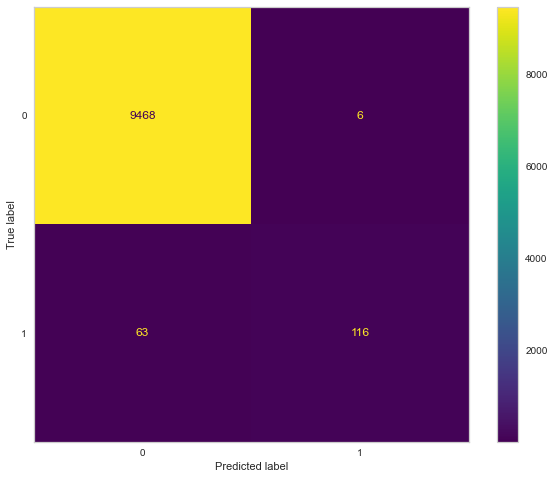

In [9]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, xgb_pred)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

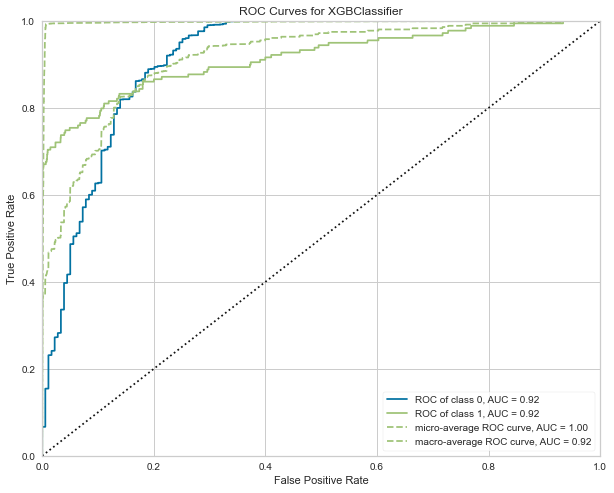

In [10]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(xgb, X_balanced, y_balanced, X_test, y_test)
plt.show()

**Just WoE Bins**

In [11]:
xgb_2 = XGBClassifier(use_label_encoder = False, eval_metric = "logloss")
xgb_2.fit(X_train, y_train)
train_score = xgb_2.score(X_train, y_train)
test_score = xgb_2.score(X_test, y_test)
xgb_pred_2 = xgb_2.predict(X_test)
print(train_score)
print(test_score)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


0.9936956135677499
0.9926447736454989


In [12]:
print(classification_report(y_test, xgb_pred_2))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9474
           1       0.96      0.63      0.76       179

    accuracy                           0.99      9653
   macro avg       0.98      0.82      0.88      9653
weighted avg       0.99      0.99      0.99      9653



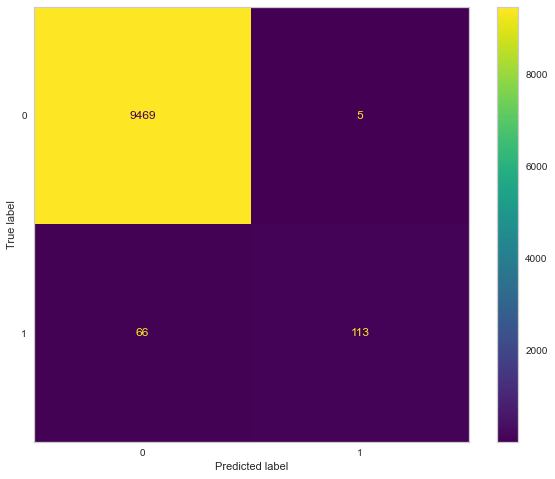

In [13]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, xgb_pred_2)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

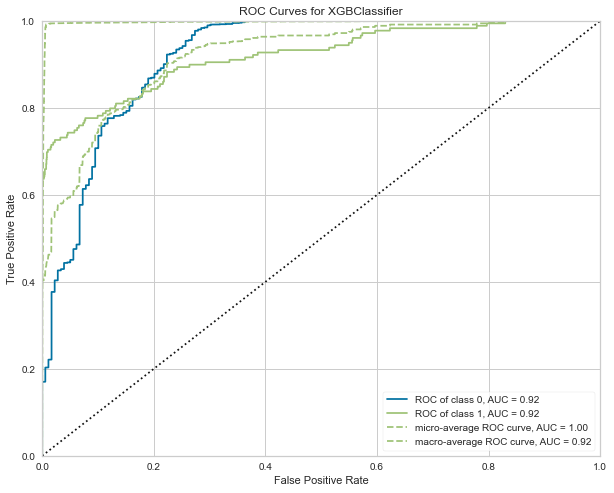

In [14]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(xgb_2, X_train, y_train, X_test, y_test)
plt.show()

## Random Forest

In [14]:
print('Training Features Shape:', X_balanced.shape)
print('Training Labels Shape:', y_balanced.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (44210, 8)
Training Labels Shape: (44210,)
Testing Features Shape: (9653, 8)
Testing Labels Shape: (9653,)


In [21]:
y= y_balanced.shape[0] + y_test.shape[0]

In [16]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Instantiate model with 1000 decision trees, base on the gridsearch best hyperpermeter
rf = RandomForestClassifier(n_estimators= 1000, max_depth= 100, max_features= 3, min_samples_leaf= 3, min_samples_split= 8, bootstrap= True)

# Train the model on training data
rf.fit(X_balanced, y_balanced)

RandomForestClassifier(max_depth=100, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=1000)

In [24]:
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)


train_adjusted_r2 = 1 - (1-rf.score(X_balanced, y_balanced)) * (y-1)/(y-8-1)
test_adjusted_r2 = 1 - (1-rf.score(X_test, y_test)) * (y-1)/(y-8-1)
print("Evaluation Metrics for Random Forest Regression")
# print(f"MAE: {mean_absolute_error(y_test, predictions)}")
# print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}")
print(f"R-squared score for train: {rf.score(X_balanced, y_balanced)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {rf.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(rf, X, y, cv=strat_k_fold)), 4)}")                
# print('Accuracy:', round(accuracy, 2), '%.')


Evaluation Metrics for Random Forest Regression
RMSE: 0.08576261629930136
R-squared score for train: 0.9966523410992988
Adjusted R-squared score for train: 0.9966518438052964
R-squared score for test: 0.9926447736454989
Adjusted R-squared score for test: 0.9926436810282219


In [25]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9474
           1       0.96      0.63      0.76       179

    accuracy                           0.99      9653
   macro avg       0.98      0.82      0.88      9653
weighted avg       0.99      0.99      0.99      9653



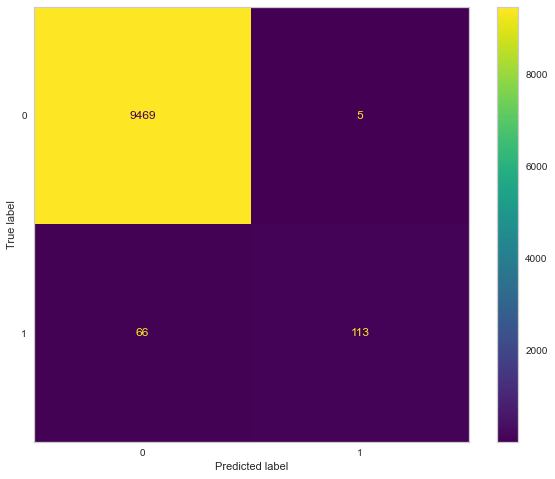

In [26]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


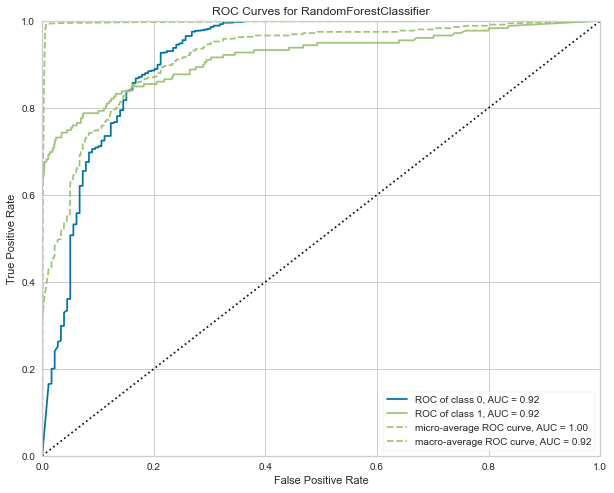

In [29]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(rf, X_balanced, y_balanced, X_test, y_test)
plt.show()

In [30]:
#with stratifiedkfold = 3 #using cvfold = 3 parameters
rf = RandomForestClassifier(n_estimators= 300, max_depth= 90, max_features= 3, min_samples_leaf= 3, min_samples_split= 8, bootstrap= True)

rf.fit(X_balanced, y_balanced);
rf_pred = rf.predict(X_test)

print("Evaluation Metrics for Random Forest Regression")
# print(f"MAE: {mean_absolute_error(y_test, rf_pred)}")
# print(f"MSE: {mean_squared_error(y_test, rf_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred))}")
print(f"R-squared score for train: {rf.score(X_balanced, y_balanced)}")
print(f"R-squared score for test: {rf.score(X_test, y_test)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(rf, X_balanced, y_balanced, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Random Forest Regression
RMSE: 0.08576261629930136
R-squared score for train: 0.9966523410992988
R-squared score for test: 0.9926447736454989
Cross Validation Score: 0.9957


In [31]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9474
           1       0.96      0.63      0.76       179

    accuracy                           0.99      9653
   macro avg       0.98      0.82      0.88      9653
weighted avg       0.99      0.99      0.99      9653



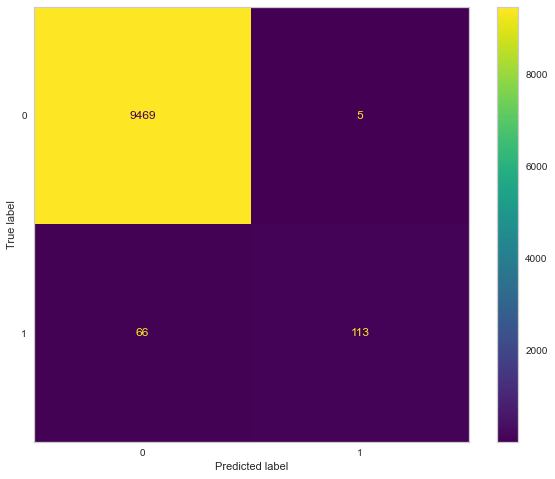

In [32]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, rf_pred)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


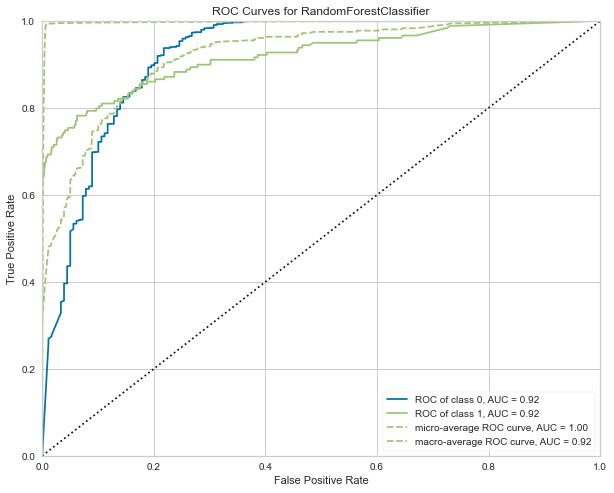

In [34]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(rf, X_balanced, y_balanced, X_test, y_test)
plt.show()

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
NN_model = Sequential()
# The Input Layer :
NN_model.add(Dense(431,input_dim = 8, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(200,activation='relu'))
NN_model.add(Dense(145, activation='relu'))
NN_model.add(Dense(55,activation='relu'))
NN_model.add(Dense(25,activation='relu'))
NN_model.add(Dense(10,activation='relu'))


# The Output Layer :
NN_model.add(Dense(1, activation='relu'))

# Compile the network :
NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NN_model.fit(X_balanced, y_balanced, epochs=20, batch_size=5)

Epoch 1/20
8842/8842 [==============================] - 55s 6ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/20
8842/8842 [==============================] - 59s 7ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/20
8842/8842 [==============================] - 59s 7ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/20
8842/8842 [==============================] - 52s 6ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/20
8842/8842 [==============================] - 52s 6ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/20
8842/8842 [==============================] - 54s 6ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/20
8842/8842 [==============================] - 51s 6ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 8/20
8842/8842 [==============================] - 48s 5ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 9/20
8842/8842 [==============================] - 49s 6ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 10/20
8842/8842 [==============================] - 49s 6ms/step - l

In [40]:
# predictions = NN_model.predict(X_test_scaled)
# predictions_classes = np.argmax(predictions, axis=-1)
_, accuracy = NN_model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

302/302 [==============================] - 1s 4ms/step - loss: 0.2860 - accuracy: 0.9815
Accuracy: 98.15


In [42]:
y_pred = NN_model.predict(X_test)
y_pred_class = []
for i in y_pred.ravel():
    if i > 0.5:
        y_pred_class.append(1)
    else:
        
        y_pred_class.append(0)
y_pred_class

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


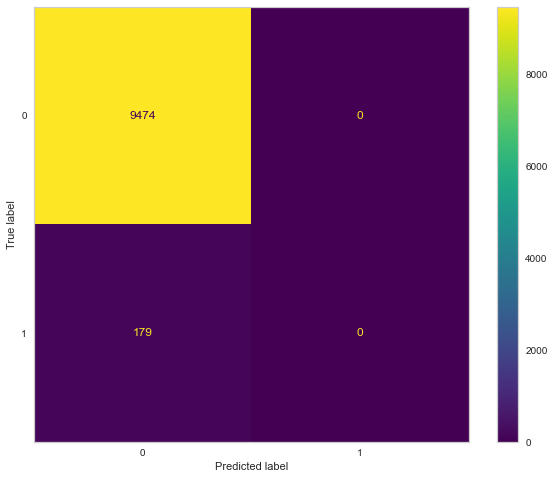

In [43]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred_class)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

0.49994722398142283


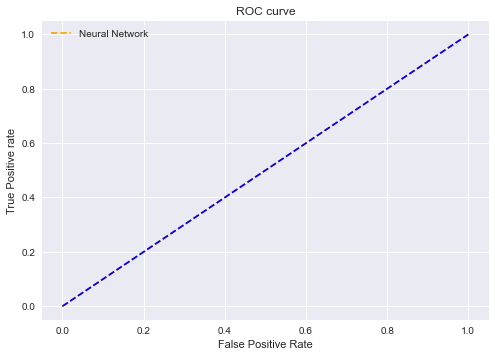

In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_score1 = roc_auc_score(y_test, y_pred)
# auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
print(auc_score1)

plt.style.use('seaborn')
# plot roc curves
plt.plot(nn_fpr_keras, nn_tpr_keras, linestyle='--',color='orange', label='Neural Network')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();
# plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
# plt.rcParams["figure.figsize"] = (10,8)
# plot_ROC_curve(NN_model, X_balanced, y_balanced, X_test_scaled, y_test)
# plt.show()

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(X_test_scaled, y_pred_class)
# print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_class)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_class)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_class)
print('F1 score: %f' % f1)

Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree

In [12]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(max_depth=12, criterion="entropy", min_samples_leaf=2)
tree = dt.fit(X_balanced, y_balanced)

dt_pred=tree.predict(X_test)

#Accuracy score
print(f"Accuracy train:  {round(tree.score(X_balanced, y_balanced), 4)}")
print(f"Accuracy test:  {round(tree.score(X_test, y_test),4 )}")



Accuracy train:  0.9872
Accuracy test:  0.9848


In [13]:
print(f'Classification Report Decision Tree: \n{classification_report(y_test, dt_pred)}')

Classification Report Decision Tree: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9474
           1       0.58      0.63      0.60       179

    accuracy                           0.98      9653
   macro avg       0.79      0.81      0.80      9653
weighted avg       0.99      0.98      0.99      9653



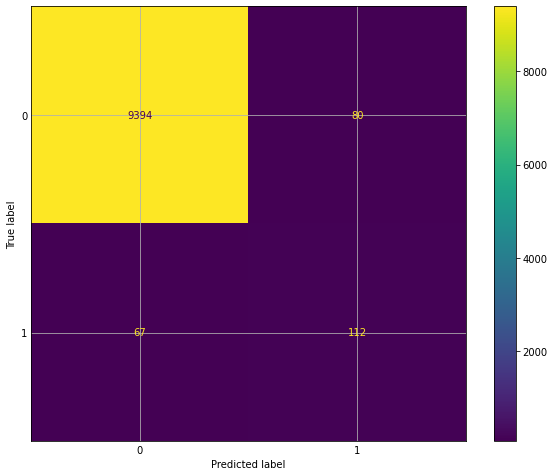

In [14]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, dt_pred)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

C:\Users\Sherman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


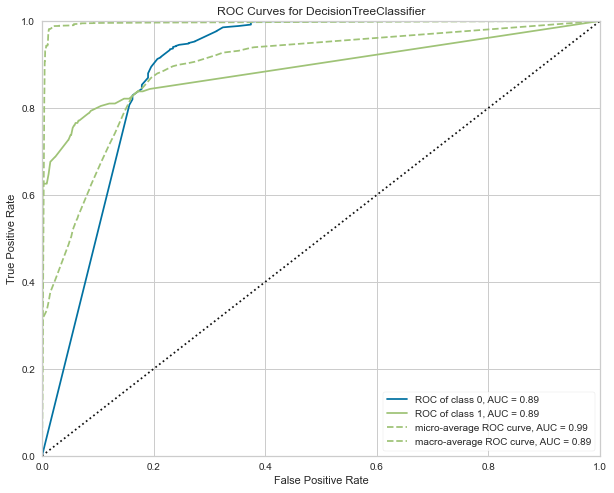

In [18]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(dt, X_balanced, y_balanced, X_test, y_test)
plt.show()

# Logistic Regression

In [20]:
lr = LogisticRegression(random_state=0).fit(X_balanced, y_balanced)
lr_pred = lr.predict(X_test)

print(f"Accuracy train:  T2: {round(lr.score(X_balanced, y_balanced), 4)}")
print(f"Accuracy test: T2: {round(lr.score(X_test, y_test),4 )}")


Accuracy train:  T2: 0.7706
Accuracy test: T2: 0.7354


In [21]:
print(f'Classification Report Logistic Regression: \n{classification_report(y_test, lr_pred)}')

Classification Report Logistic Regression: 
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      9474
           1       0.05      0.74      0.09       179

    accuracy                           0.74      9653
   macro avg       0.52      0.74      0.47      9653
weighted avg       0.98      0.74      0.83      9653



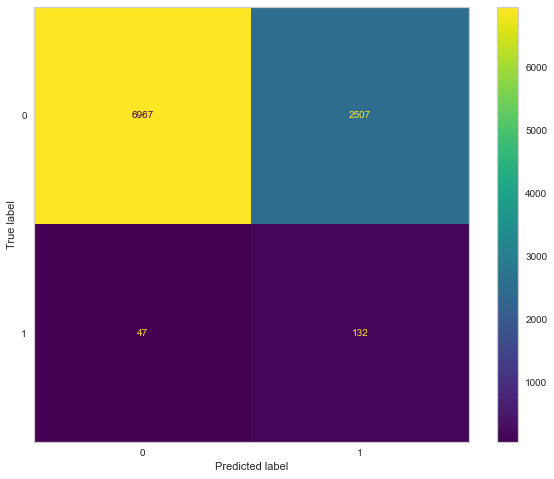

In [22]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, lr_pred)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

C:\Users\Sherman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


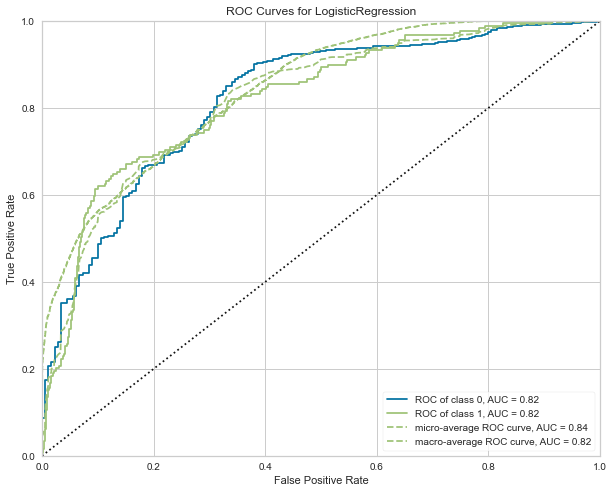

In [23]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(lr, X_balanced, y_balanced, X_test, y_test)
plt.show()

# SVM

In [7]:
from sklearn.svm import SVC

In [8]:
classif_lnr = SVC(kernel="linear", probability=False, random_state=42, verbose=True)
classif_lnr.fit(X_balanced, y_balanced)
svc_lnr_train_score = classif_lnr.score(X_balanced, y_balanced)
svc_lnr_test_score = classif_lnr.score(X_test, y_test)
svc_lnr_pred = classif_lnr.predict(X_test)

print(f"SVC w/ Linear Kernel Train Score: {svc_lnr_train_score}\n")
print(f"SVC w/ Linear Kernel Test Score: {svc_lnr_test_score}")

[LibSVM]SVC w/ Linear Kernel Train Score: 0.6742365980547388

SVC w/ Linear Kernel Test Score: 0.5177664974619289


In [9]:
print(f'Classification Report Linear Kernel SVC: \n{classification_report(y_test, svc_lnr_pred)}')

Classification Report Linear Kernel SVC: 
              precision    recall  f1-score   support

           0       0.99      0.51      0.68      9474
           1       0.03      0.79      0.06       179

    accuracy                           0.52      9653
   macro avg       0.51      0.65      0.37      9653
weighted avg       0.97      0.52      0.66      9653



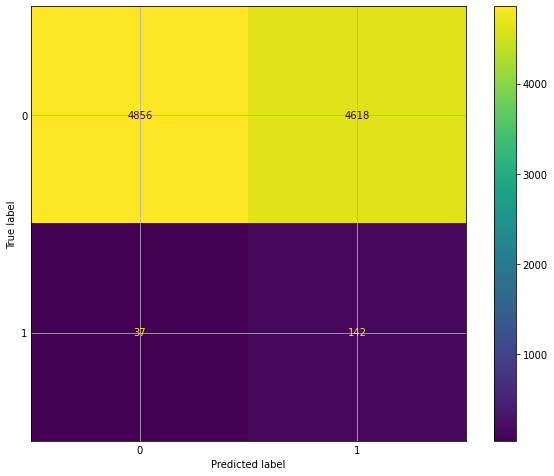

In [10]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, svc_lnr_pred)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

C:\Users\Sherman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


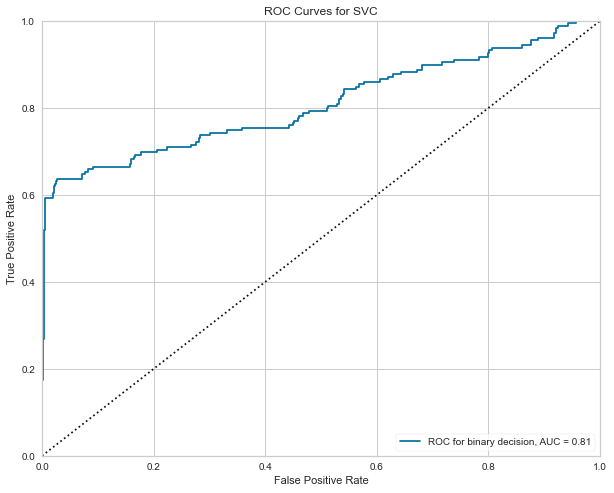

In [15]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(classif_lnr, X_balanced, y_balanced, X_test, y_test)
plt.show()

In [17]:
classif_rbf = SVC(kernel="rbf", probability=False, random_state=42)
classif_rbf.fit(X_balanced, y_balanced)
svc_rbf_train_score = classif_rbf.score(X_balanced, y_balanced)
svc_rbf_test_score = classif_rbf.score(X_test, y_test)
svc_rbf_pred = classif_rbf.predict(X_test)

print(f"SVC w/ RBF Kernel Train Score: {svc_rbf_train_score}\n")
print(f"SVC w/ RBF Kernel Test Score: {svc_rbf_test_score}\n")

SVC w/ RBF Kernel Train Score: 0.767993666591269

SVC w/ RBF Kernel Test Score: 0.9199212679995856



In [18]:
print(f'Classification Report RBF Kernel SVC: \n{classification_report(y_test, svc_rbf_pred)}')

Classification Report RBF Kernel SVC: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      9474
           1       0.14      0.64      0.23       179

    accuracy                           0.92      9653
   macro avg       0.57      0.78      0.59      9653
weighted avg       0.98      0.92      0.94      9653



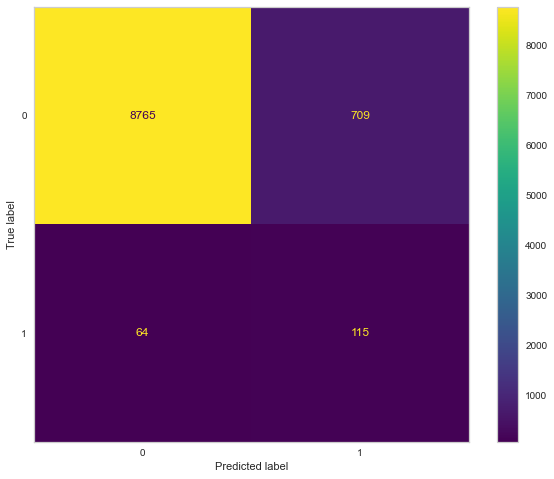

In [19]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, svc_rbf_pred)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

C:\Users\Sherman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


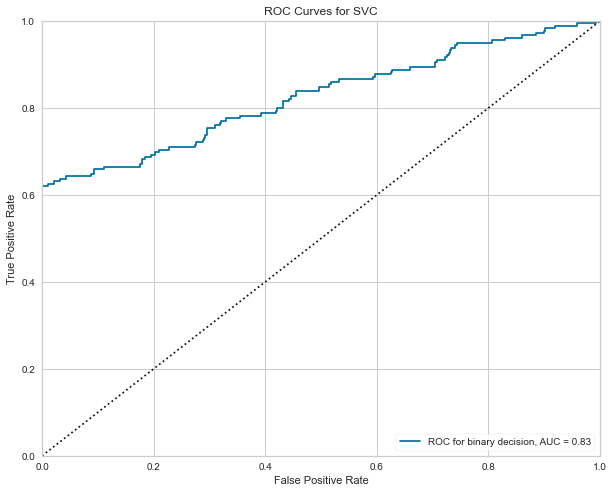

In [22]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(classif_rbf, X_balanced, y_balanced, X_test, y_test)
plt.show()